# Imports + paramètres

- imports
- pattern_size, square_size
- chemins data/chessboards, data/scanLeft, data/scanRight
- plt.rcParams...

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

plt.rcParams["figure.figsize"] = (12, 7) # (10,6)

# Calibration mono (Left + Right)

- detect_chessboard_corners()
- Debug visuel sur 1 paire
- build_object_points() 
- calibrate_camera()
- Exemple d’exécution → affiche RMS, K, dist, + check RMS < 15px

Corner detection - Left: True | Right: True
Left corners shape : (49, 1, 2)
Right corners shape: (49, 1, 2)


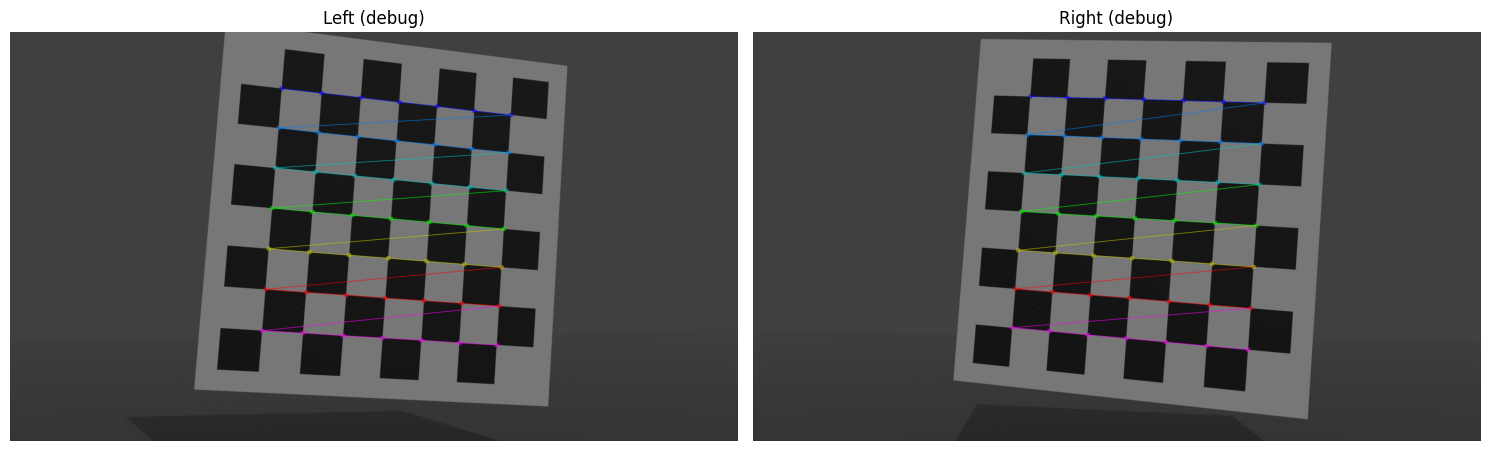

Found Left images: 4 -> ['c1Left.png', 'c2Left.png', 'c3Left.png', 'c4Left.png']
Found Right images: 4 -> ['c1Right.png', 'c2Right.png', 'c3Right.png', 'c4Right.png']

Successfully calibrated LEFT on 4 images.
Successful LEFT images list: ['c1Left.png', 'c2Left.png', 'c3Left.png', 'c4Left.png']

Successfully calibrated RIGHT on 4 images.
Successful RIGHT images list: ['c1Right.png', 'c2Right.png', 'c3Right.png', 'c4Right.png']

 LEFT CAMERA
RMS: 0.03827474159298447
K_L:
 [[2.09991466e+03 0.00000000e+00 9.60187506e+02]
 [0.00000000e+00 2.09991624e+03 5.38595868e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_L: [-6.88040473e-03  1.42797318e-01 -1.76651995e-04  1.46989865e-04
 -3.30431598e-01]

 RIGHT CAMERA
RMS: 0.04181482740498828
K_R:
 [[2.10006435e+03 0.00000000e+00 9.59760241e+02]
 [0.00000000e+00 2.09997317e+03 5.39852296e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_R: [-5.48447501e-03  2.17369294e-01  7.18268312e-06  2.78567662e-05
 -2.47917238e+00]

Check

: 

: 

: 

In [ ]:

# Paramètres damier 
pattern_size = (7, 7)    # coins internes (cols, rows)
square_size  = 1.0       # taille d'un carré


#  Dossier images damier 
CB_DIR = Path("data/chessboards")
SCAN_LEFT_DIR = "data/scanLeft/*.png"
SCAN_RIGHT_DIR = "data/scanRight/*.png"

# Paire de reference pour F et P1/P2 on choisit c4 
TEST_LEFT  = CB_DIR / "c4Left.png"
TEST_RIGHT = CB_DIR / "c4Right.png"



# Détection des coins
def detect_chessboard_corners(image_path, pattern_size):
    """
    Détecte les coins internes du damier + raffinage sub-pixel.
    Retour: dict {success, corners (N,1,2), image_with_corners (RGB)}
    """
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"image introuvable : {image_path}")

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_with = img_rgb.copy()

    flags = (cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE)
    success, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    # fallback robuste si dispo (OpenCV >= 4.5)
    if not success and hasattr(cv2, "findChessboardCornersSB"):
        success, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

    if not success:
        return {"success": False, "corners": None, "image_with_corners": img_rgb}

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    corners = corners.astype(np.float32)
    refined = cv2.cornerSubPix(gray, corners, winSize=(11, 11), zeroZone=(-1, -1), criteria=criteria)

    cv2.drawChessboardCorners(img_with, pattern_size, refined, True)
    return {"success": True, "corners": refined, "image_with_corners": img_with}



# Points 3D du damier
def build_object_points(pattern_size, square_size):
    """
    Grille 3D du damier sur z=0 : (N,3) avec N = cols*rows
    """
    cols, rows = pattern_size
    objp = np.zeros((cols * rows, 3), dtype=np.float32)

    gx, gy = np.meshgrid(np.arange(cols), np.arange(rows))
    objp[:, :2] = np.column_stack((gx.ravel(), gy.ravel())) * square_size
    return objp



# Debug détection coins sur une paire
resL = detect_chessboard_corners(TEST_LEFT,  pattern_size)
resR = detect_chessboard_corners(TEST_RIGHT, pattern_size)

print(f"Corner detection - Left: {resL['success']} | Right: {resR['success']}")
if resL["success"]:
    print("Left corners shape :", resL["corners"].shape)   # (49,1,2)
if resR["success"]:
    print("Right corners shape:", resR["corners"].shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(resL["image_with_corners"]); ax1.set_title("Left (debug)");  ax1.axis("off")
ax2.imshow(resR["image_with_corners"]); ax2.set_title("Right (debug)"); ax2.axis("off")
plt.tight_layout(); plt.show()


# Calibration mono + RMS
def calibrate_camera(image_paths, pattern_size, square_size=1.0, min_valid=4):
    """
    Calibre UNE caméra à partir d’images de damier.
    Retour: rms, K, dist, rvecs, tvecs, used_images, mean_view_error, max_view_error, image_size
    """
    objp = build_object_points(pattern_size, square_size)

    obj_points, img_points, used_images = [], [], []
    image_size = None

    for p in image_paths:
        res = detect_chessboard_corners(p, pattern_size)
        if not res["success"]:
            continue

        img_bgr = cv2.imread(str(p))
        if img_bgr is None:
            continue
        h, w = img_bgr.shape[:2]
        if image_size is None:
            image_size = (w, h)
        elif image_size != (w, h):
            raise ValueError(f"Tailles d’images différentes : {p} -> {(w,h)} vs {image_size}")

        obj_points.append(objp.copy())
        img_points.append(res["corners"])
        used_images.append(p)

    if len(used_images) < min_valid:
        raise ValueError(f"Pas assez d’images valides: {len(used_images)} (min {min_valid}).")

    rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, image_size, None, None
    )

    # reprojection error par vue (diagnostic simple)
    per_view_errors = []
    for objp_i, imgp_i, rvec, tvec in zip(obj_points, img_points, rvecs, tvecs):
        proj, _ = cv2.projectPoints(objp_i, rvec, tvec, K, dist)
        err = np.sqrt(np.mean(np.sum((imgp_i - proj) ** 2, axis=2)))
        per_view_errors.append(float(err))

    return {
        "rms": float(rms),
        "K": K,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "used_images": used_images,
        "mean_view_error": float(np.mean(per_view_errors)),
        "max_view_error": float(np.max(per_view_errors)),
        "image_size": image_size,
    }



# Exécution Left / Right
left_paths  = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Left*.*")))
right_paths = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Right*.*")))

print(f"Found Left images: {len(left_paths)} ->", [p.name for p in left_paths])
print(f"Found Right images: {len(right_paths)} ->", [p.name for p in right_paths])

calibL = calibrate_camera(left_paths,  pattern_size, square_size, min_valid=4)
calibR = calibrate_camera(right_paths, pattern_size, square_size, min_valid=4)

print(f"\nSuccessfully calibrated LEFT on {len(calibL['used_images'])} images.")
print("Successful LEFT images list:", [p.name for p in calibL["used_images"]])

print(f"\nSuccessfully calibrated RIGHT on {len(calibR['used_images'])} images.")
print("Successful RIGHT images list:", [p.name for p in calibR["used_images"]])

print("\n LEFT CAMERA")
print("RMS:", calibL["rms"])
print("K_L:\n", calibL["K"])
print("dist_L:", calibL["dist"].ravel())

print("\n RIGHT CAMERA")
print("RMS:", calibR["rms" ])
print("K_R:\n", calibR["K"])
print("dist_R:", calibR["dist"].ravel())

THRESH_RMS = 15.0
print("\nCheck RMS < 15 px:",
      "Left OK" if calibL["rms"] < THRESH_RMS else "Left FAIL",
      "|",
      "Right OK" if calibR["rms"] < THRESH_RMS else "Right FAIL")


# Matrice fondamentale F

- Estimer F à partir de correspondances (coins du damier)
- F 8POINT
- F RANSAC
- Comparer 8POINT vs RANSAC
- Vérifier la contrainte x'^T F x ≈ 0



In [ ]:
# Paire de référence
# c4 est souvent la plus "planar" et la plus stable)
imgL_path = CB_DIR / "c4Left.png"
imgR_path = CB_DIR / "c4Right.png"

resL = detect_chessboard_corners(imgL_path, pattern_size)
resR = detect_chessboard_corners(imgR_path, pattern_size)

if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie.")

ptsL = resL["corners"].reshape(-1, 2).astype(np.float64)  # (N,2)
ptsR = resR["corners"].reshape(-1, 2).astype(np.float64)

print("Nb correspondances (damier) :", ptsL.shape[0])  # attendu 49
"\n"


# F sans robustesse (8POINT)
F_8, _ = cv2.findFundamentalMat(ptsL, ptsR, method=cv2.FM_8POINT)
if F_8 is None:
    raise RuntimeError("Échec estimation F (8POINT).")

# Normalisation 
F_8 = F_8 / (np.linalg.norm(F_8) + 1e-12)

print("F (8POINT) :\n", F_8)
"\n"

# F robuste (RANSAC)
F_RANSAC, mask = cv2.findFundamentalMat(
    ptsL, ptsR,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,  # seuil en pixels
    confidence=0.99
)

if F_RANSAC is None:
    raise RuntimeError("Échec estimation F (RANSAC).")

F_RANSAC = F_RANSAC / (np.linalg.norm(F_RANSAC) + 1e-12)

inliers_L = ptsL[mask.ravel() == 1]
inliers_R = ptsR[mask.ravel() == 1]

print("\nF (RANSAC) :\n", F_RANSAC)
"\n"
print("Inliers RANSAC :", len(inliers_L), "/", len(ptsL))



# Vérification x'^T F x ≈ 0 + comparaison

def epipolar_residuals(F, ptsL, ptsR):
    ptsL_h = np.hstack([ptsL, np.ones((ptsL.shape[0], 1))])  # (N,3)
    ptsR_h = np.hstack([ptsR, np.ones((ptsR.shape[0], 1))])  # (N,3)
    Fx = (F @ ptsL_h.T).T                                    # (N,3)
    vals = np.sum(ptsR_h * Fx, axis=1)                       # x'^T (F x)
    return np.abs(vals)

err8 = epipolar_residuals(F_8, ptsL, ptsR)
errR = epipolar_residuals(F_RANSAC, inliers_L, inliers_R)

"\n"
print("\n Résidus épipolaires |x'^T F x|")
print(f"8POINT : mean={np.mean(err8):.6f} | max={np.max(err8):.6f}")
print(f"RANSAC : mean={np.mean(errR):.6f} | max={np.max(errR):.6f}")

#print("\nConclusion: on garde F_RANSAC (plus robuste / meilleurs résidus).")


Nb correspondances (damier) : 49
F (8POINT) :
 [[ 5.35494821e-07  8.63153741e-07 -3.87675362e-03]
 [-7.21961356e-08  1.23534960e-09 -4.05098486e-03]
 [ 2.32724431e-03  3.29229082e-03  9.99976152e-01]]

F (RANSAC) :
 [[ 3.67572290e-07 -4.00331143e-05  2.35346420e-02]
 [ 4.12127595e-05 -6.55199397e-08 -4.69028631e-02]
 [-2.50164000e-02  4.59554588e-02  9.97250477e-01]]
Inliers RANSAC : 49 / 49

 Résidus épipolaires |x'^T F x|
8POINT : mean=0.000136 | max=0.000485
RANSAC : mean=0.000431 | max=0.001560


: 

: 

: 

# Lignes épipolaires 

- Prendre quelques coins du damier (LEFT)
- Calculer les épipolaires dans RIGHT : l' = F x
- Dessiner ces lignes dans RIGHT + afficher les points RIGHT correspondants




Nb coins: 49


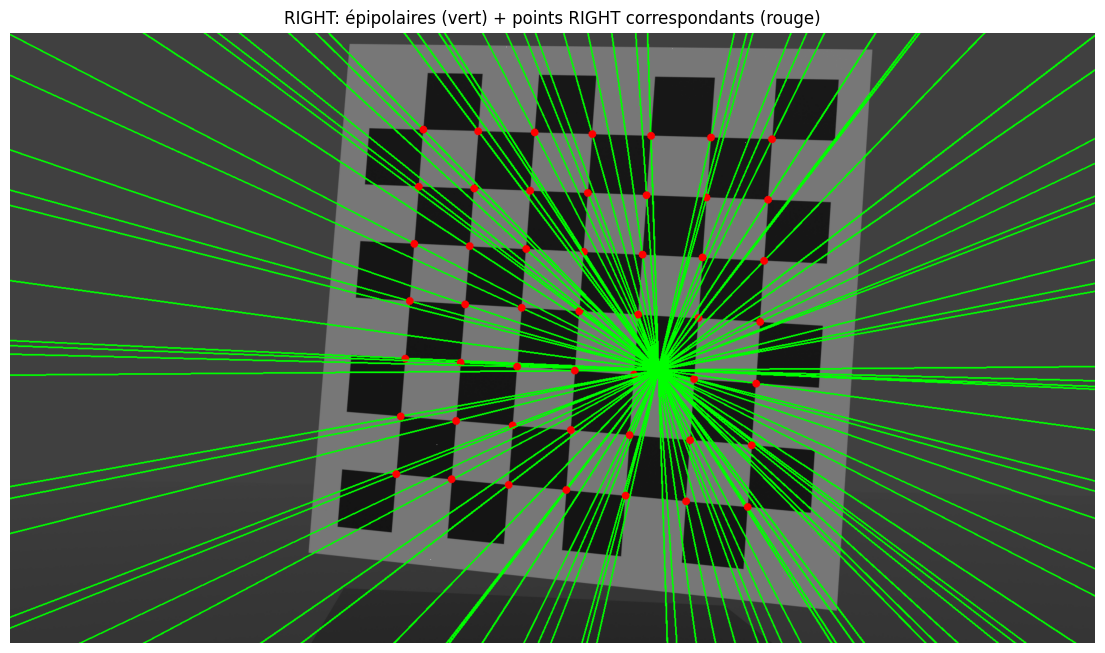

Distances point->ligne (px):
  mean = 0.03324837701062424  | max = 0.09637617007987269


: 

: 

: 

In [ ]:

# - On utilise les coins du damier : pts_left[i] - pts_right[i]
# - Donc la ligne i (calculée depuis LEFT) doit passer par le point RIGHT i.

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def to_homogeneous(pts):
    return np.hstack([pts, np.ones((pts.shape[0], 1), dtype=np.float64)])

def epilines_right_from_left(F, pts_left):
    X = to_homogeneous(pts_left)       # (N,3)
    lines = (F @ X.T).T                # (N,3) : [a,b,c]
    return lines

def draw_line_axbyc(img_rgb, line, thickness=2):
    """Dessine une ligne ax+by+c=0 sur l'image."""
    out = img_rgb.copy()
    h, w = out.shape[:2]
    a, b, c = line

    if abs(b) > 1e-12:
        # x=0 et x=w-1
        y0 = int(round((-c - a*0) / b))
        y1 = int(round((-c - a*(w-1)) / b))
        cv2.line(out, (0, y0), (w-1, y1), (0,255,0), thickness)
    else:
        # verticale
        if abs(a) < 1e-12:
            return out
        x = int(round(-c / a))
        cv2.line(out, (x, 0), (x, h-1), (0,255,0), thickness)

    return out

def draw_point(img_rgb, pt, r=7):
    out = img_rgb.copy()
    x, y = pt
    cv2.circle(out, (int(round(x)), int(round(y))), r, (255,0,0), -1)
    return out


# Choisir la paire pour la visu (prends c4 si possible)
imgL_path = CB_DIR / "c4Left.png"
imgR_path = CB_DIR / "c4Right.png"

resL = detect_chessboard_corners(imgL_path, pattern_size)
resR = detect_chessboard_corners(imgR_path, pattern_size)
if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie pour les épipolaires.")

pts_left  = resL["corners"].reshape(-1, 2).astype(np.float64)   # (49,2)
pts_right = resR["corners"].reshape(-1, 2).astype(np.float64)   # (49,2)

print("Nb coins:", len(pts_left))


# Sélectionner quelques points (plus lisible)
# 10 points espacés sur tout le damier
idx = np.linspace(0, len(pts_left)-1, 4000).astype(int)

# une rangée complète (7 points)
# row = 3  # rangée du milieu (0..6)
# idx = np.arange(row*7, (row+1)*7)

ptsL_vis = pts_left[idx]
ptsR_vis = pts_right[idx]


# Calculer les lignes épipolaires dans RIGHT : l' = F x_left
linesR = epilines_right_from_left(F_RANSAC if "F_RANSAC" in globals() else F, ptsL_vis)


# Affichage RIGHT : lignes + points correspondants
imgR_bgr = cv2.imread(str(imgR_path))
imgR_rgb = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)
out = imgR_rgb.copy()

for line, ptR in zip(linesR, ptsR_vis):
    out = draw_line_axbyc(out, line, thickness=2)
    out = draw_point(out, ptR, r=7)

plt.figure(figsize=(14,10))
plt.imshow(out)
plt.title("RIGHT: épipolaires (vert) + points RIGHT correspondants (rouge)")
plt.axis("off")
plt.show()

# Diagnostic distance point->ligne (doit être petit)
def point_line_distance(line, pt):
    a,b,c = line
    x,y = pt
    return abs(a*x + b*y + c) / (np.sqrt(a*a + b*b) + 1e-12)

dists = [point_line_distance(l, p) for l,p in zip(linesR, ptsR_vis)]
print("Distances point->ligne (px):")
print("  mean =", float(np.mean(dists)), " | max =", float(np.max(dists)))


### RECTIFICATION (alpha=1) + épilignes horizontales sur les coins


Rectified corners |Δy| : mean=0.0531 px | max=0.1813 px


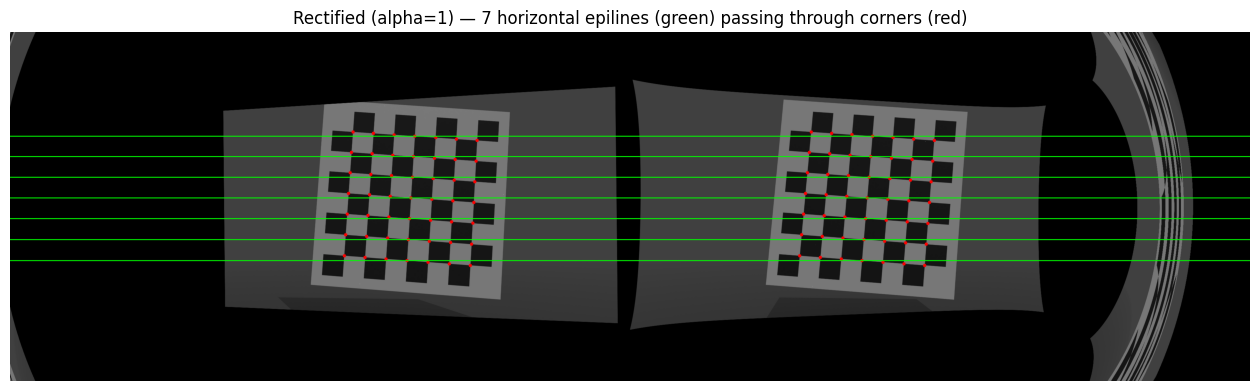

: 

: 

: 

In [ ]:



# mini-helpers 
def find_idx(used_images, target_path: Path):
    name = target_path.name
    for i, p in enumerate(used_images):
        if Path(p).name == name:
            return i
    return None

def detect_corners_bgr(img_bgr, pattern_size):
    """Corners + subpixel sur image déjà chargée (BGR)."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    ok, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    if (not ok) and hasattr(cv2, "findChessboardCornersSB"):
        ok, corners = cv2.findChessboardCornersSB(gray, pattern_size, None)

    if not ok:
        return None

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    corners = cv2.cornerSubPix(gray, corners.astype(np.float32), (11,11), (-1,-1), criteria)
    return corners.reshape(-1, 2)  # (N,2)

def draw_hlines(canvas_rgb, ys, thickness=2):
    out = canvas_rgb.copy()
    H, W = out.shape[:2]
    for y in ys:
        y = int(np.clip(round(y), 0, H-1))
        cv2.line(out, (0, y), (W-1, y), (0,255,0), thickness)
    return out

def show(img_rgb, title=""):
    plt.figure(figsize=(16,7))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

#paramètres / paire référence 
K_L, dist_L = calibL["K"], calibL["dist"]
K_R, dist_R = calibR["K"], calibR["dist"]
img_size = tuple(calibL["image_size"])  # (w,h)

REF_LEFT  = CB_DIR / "c4Left.png"
REF_RIGHT = CB_DIR / "c4Right.png"

idxL = find_idx(calibL["used_images"], REF_LEFT)
idxR = find_idx(calibR["used_images"], REF_RIGHT)
if idxL is None or idxR is None:
    raise RuntimeError("REF_LEFT/REF_RIGHT pas présents dans used_images -> choisis une paire détectée (c2, c4, etc).")

# pose relative (R_rel, T_rel)
rvecL, tvecL = calibL["rvecs"][idxL], calibL["tvecs"][idxL]
rvecR, tvecR = calibR["rvecs"][idxR], calibR["tvecs"][idxR]

R_left,  _ = cv2.Rodrigues(rvecL)
R_right, _ = cv2.Rodrigues(rvecR)

t_left  = tvecL.reshape(3,1)
t_right = tvecR.reshape(3,1)

R_rel = R_right @ R_left.T
T_rel = t_right - R_rel @ t_left

# rectification (alpha = 1)
alpha = 1
R1, R2, P1_rect, P2_rect, Q, _, _ = cv2.stereoRectify(
    K_L, dist_L, K_R, dist_R, img_size, R_rel, T_rel,
    flags=cv2.CALIB_ZERO_DISPARITY, alpha=alpha
)

map1x, map1y = cv2.initUndistortRectifyMap(K_L, dist_L, R1, P1_rect, img_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(K_R, dist_R, R2, P2_rect, img_size, cv2.CV_32FC1)

# rectifier images 
imgL_bgr = cv2.imread(str(REF_LEFT))
imgR_bgr = cv2.imread(str(REF_RIGHT))
if imgL_bgr is None or imgR_bgr is None:
    raise FileNotFoundError("Impossible de lire les images REF_LEFT/REF_RIGHT.")

rectL = cv2.remap(imgL_bgr, map1x, map1y, cv2.INTER_LINEAR)
rectR = cv2.remap(imgR_bgr, map2x, map2y, cv2.INTER_LINEAR)

rectL_rgb = cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB)
rectR_rgb = cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB)

# coins sur rectifiées 
ptsL = detect_corners_bgr(rectL, pattern_size)
ptsR = detect_corners_bgr(rectR, pattern_size)

# Canvas LEFT|RIGHT
H, W = rectL_rgb.shape[:2]
canvas = np.hstack([rectL_rgb, rectR_rgb])

if ptsL is None or ptsR is None:
    # fallback propre : lignes horizontales uniformes
    ys = np.linspace(0, H-1, 18)
    show(draw_hlines(canvas, ys, thickness=1), "Rectified (alpha=1) + horizontal lines (corners not detected)")
else:
    # Vérif Δy
    dy = np.abs(ptsL[:,1] - ptsR[:,1])
    print(f"Rectified corners |Δy| : mean={float(np.mean(dy)):.4f} px | max={float(np.max(dy)):.4f} px")

    # 1 ligne par rangée du damier (7 lignes)
    cols, rows = pattern_size  # (7,7)
    ys_rows = []
    for r in range(rows):
        ys_rows.append(np.mean(ptsR[r*cols:(r+1)*cols, 1]))
    ys_rows = np.array(ys_rows)

    # SI je veux voir toutes les lignes horizontales
    #ys_rows = np.linspace(0, H-1, 18)


    # Dessiner coins (rouge) + lignes horizontales (vertes)
    out = canvas.copy()
    for (x,y) in ptsL:
        cv2.circle(out, (int(round(x)), int(round(y))), 5, (255,0,0), -1)
    for (x,y) in ptsR:
        cv2.circle(out, (int(round(x+W)), int(round(y))), 5, (255,0,0), -1)

    out = draw_hlines(out, ys_rows, thickness=2)
    show(out, "Rectified (alpha=1) — 7 horizontal epilines (green) passing through corners (red)")


# Matrices de projection P1, P2

- Construire P1 et P2 pour la triangulation 3D
- P = K [R | t]
- La caméra LEFT est prise comme référence


In [ ]:

# Choix explicite de la paire de référence
REF_LEFT  = CB_DIR / "c4Left.png"
REF_RIGHT = CB_DIR / "c4Right.png"

def find_image_index(used_images, target_path):
    target_name = Path(target_path).name
    for i, p in enumerate(used_images):
        if Path(p).name == target_name:
            return i
    return None

idxL = find_image_index(calibL["used_images"], REF_LEFT)
idxR = find_image_index(calibR["used_images"], REF_RIGHT)

if idxL is None or idxR is None:
    raise RuntimeError("Paire de référence non trouvée dans used_images.")

# Récupération rvec / tvec de la MÊME paire
rvec_left  = calibL["rvecs"][idxL]
tvec_left  = calibL["tvecs"][idxL]

rvec_right = calibR["rvecs"][idxR]
tvec_right = calibR["tvecs"][idxR]

print("Left rvec:", rvec_left.ravel())
print("Left tvec:", tvec_left.ravel())
print("Right rvec:", rvec_right.ravel())
print("Right tvec:", tvec_right.ravel())


# Conversion Rodrigues → matrices de rotation
R_left,  _ = cv2.Rodrigues(rvec_left)
R_right, _ = cv2.Rodrigues(rvec_right)

# Pose RELATIVE de RIGHT par rapport à LEFT
R_rel = R_right @ R_left.T
t_rel = tvec_right.reshape(3, 1) - R_rel @ tvec_left.reshape(3, 1)

# Construction des matrices de projection-
K_L = calibL["K"]
K_R = calibR["K"]

# Caméra LEFT = référence
P1 = K_L @ np.hstack((np.eye(3), np.zeros((3, 1))))

# si je veux camera RIGHT comme reference
#P1 = K_R @ np.hstack((np.eye(3), np.zeros((3, 1))))

# Caméra RIGHT dans le repère LEFT
P2 = K_R @ np.hstack((R_rel, t_rel))

# Vérifications
print("P1 shape:", P1.shape)
print("P2 shape:", P2.shape)

assert P1.shape == (3, 4)
assert P2.shape == (3, 4)

print("ÉTAPE 4 OK : matrices de projection P1 et P2 construites.")

# À partir des paramètres intrinsèques et des poses extrinsèques issues de la calibration, nous construisons les matrices de projection P1 et P2 sous la forme P = K [R | t]. La caméra gauche est prise comme référence, et la caméra droite est exprimée dans ce même repère. Ces matrices sont ensuite utilisées pour la triangulation 3D.



Left rvec: [-0.06159508 -0.18160335  0.07799599]
Left tvec: [-2.3029941  -3.6596216  19.81851786]
Right rvec: [-0.04620213  0.21536315  0.06880971]
Right tvec: [-2.25636866 -3.62581147 20.6965445 ]
P1 shape: (3, 4)
P2 shape: (3, 4)
ÉTAPE 4 OK : matrices de projection P1 et P2 construites.


: 

: 

: 

# Triangulation damier (validation 3D)

- Détecter les coins (LEFT/RIGHT) sur une paire de référence
- Trianguler avec P1,P2 -> points 3D
- Vérifier que le damier est (quasi) PLAN
- Visualiser le nuage 3D




Nb coins: 49
3D points valides: 49
Planarity check: thickness=0.001086 | spread=2.020619 | ratio=0.000538
Attendu: ratio très petit (ex: < 0.02) => nuage quasi-plan


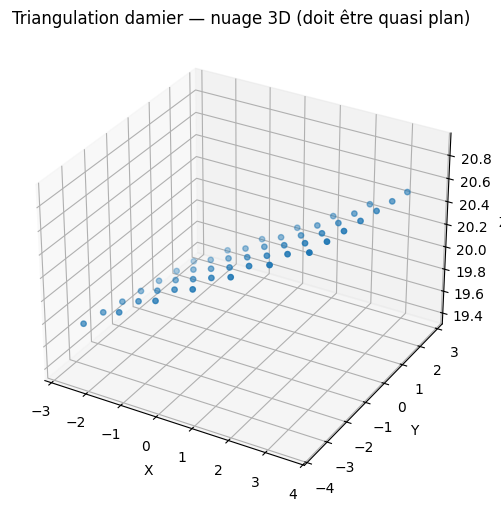

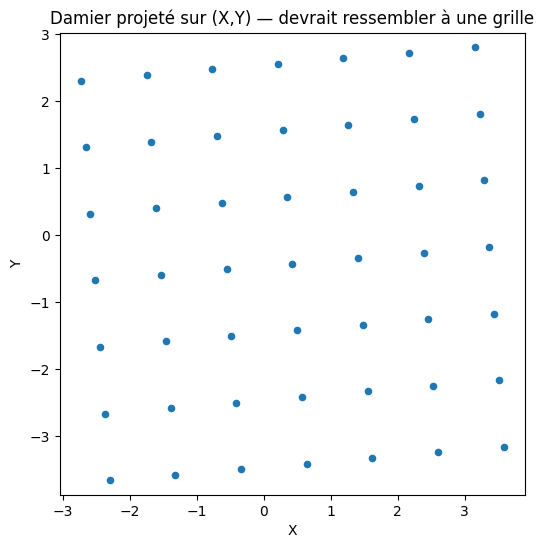

: 

: 

: 

In [ ]:
# Choisir une paire où le damier est bien détecté
PAIR_LEFT  = CB_DIR / "c4Left.png"
PAIR_RIGHT = CB_DIR / "c4Right.png"

resL = detect_chessboard_corners(PAIR_LEFT, pattern_size)
resR = detect_chessboard_corners(PAIR_RIGHT, pattern_size)

if not (resL["success"] and resR["success"]):
    raise RuntimeError("Damier non détecté sur la paire choisie.")

ptsL = resL["corners"].reshape(-1, 2).astype(np.float64)  # (N,2)
ptsR = resR["corners"].reshape(-1, 2).astype(np.float64)  # (N,2)
N = len(ptsL)
print("Nb coins:", N)

# Triangulation (OpenCV attend des tableaux 2xN)
X_h = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)  # (4,N)
X = (X_h[:3, :] / (X_h[3, :] + 1e-12)).T            # (N,3)
# IL FAUT NORMALISER par W pour obtenir (X,Y,Z)
# OU MACTCHING PAIRE PAS CORRECT

# Nettoyage basique
X = X[np.isfinite(X).all(axis=1)]
# en général, le damier doit être devant la caméra (Z > 0)
X = X[X[:, 2] > 0]

print("3D points valides:", X.shape[0])

# Vérification "planarité" : PCA -> épaisseur du plan
# Si le damier est plan, la plus petite variance (3e axe) doit être très faible
Xc = X - X.mean(axis=0, keepdims=True)
cov = (Xc.T @ Xc) / max(len(Xc) - 1, 1)
eigvals, eigvecs = np.linalg.eigh(cov)          # trié croissant
eigvals = np.sort(eigvals)

# "épaisseur" ~ sqrt(min variance)
thickness = float(np.sqrt(max(eigvals[0], 0.0)))
spread1 = float(np.sqrt(max(eigvals[2], 0.0)))  # plus grande extension
ratio = thickness / (spread1 + 1e-12)

print(f"Planarity check: thickness={thickness:.6f} | spread={spread1:.6f} | ratio={ratio:.6f}")
print("Attendu: ratio très petit (ex: < 0.02) => nuage quasi-plan")

# Plot 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=15)
ax.set_title("Triangulation damier — nuage 3D (doit être quasi plan)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

# plot 2D (X,Y) pour voir la grille
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=20)
plt.title("Damier projeté sur (X,Y) — devrait ressembler à une grille")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.show()

# “Je triangule les coins du damier. Comme le damier est un objet plan, la reconstruction doit être quasi plane. Je le vérifie via PCA : la variance normale au plan est très faible.”



# Laser 
- masque laser left + right (canal rouge ou HSV)
- extraction ligne laser (1 point/colonne)
- matching épipolaire (point right le + proche de la ligne)
- triangulation scan par scan
- accumulation X_all
- plot nuage final



In [ ]:

# reconstruction 3D de scans laser
F = F_RANSAC          # matrice fondamentale (bloc damier)
P1r, P2r = P1_rect, P2_rect   # projections rectifiées (bloc rectif)

SCAN_LEFT  = sorted(glob.glob("data/scanLeft/*.png"))
SCAN_RIGHT = sorted(glob.glob("data/scanRight/*.png"))
print("Found scan pairs:", len(SCAN_LEFT))

def laser_mask_red_score(img_bgr, thresh=40):
    b,g,r = cv2.split(img_bgr)
    score = r.astype(np.int16) - np.maximum(g,b).astype(np.int16)
    return ((score > thresh).astype(np.uint8) * 255)

# un bon à corriger ici avec les fonctions précédentes
def extract_laser_points_1perrow(mask, min_pixels_row=1):
    H, W = mask.shape
    pts = []
    
    for y in range(H):
        xs = np.where(mask[y] > 0)[0]
        if len(xs) >= min_pixels_row:
            pts.append([float(np.mean(xs)), float(y)])
    return np.array(pts, dtype=np.float64)

def match_by_y(ptsL, ptsR, max_dy=1.0):
    if len(ptsL)==0 or len(ptsR)==0:
        return np.empty((0,2)), np.empty((0,2))
    yR = ptsR[:,1]
    outL, outR = [], []
    for xL,yL in ptsL:
        j = np.argmin(np.abs(yR - yL))
        if abs(yR[j] - yL) <= max_dy:
            outL.append([xL,yL])
            outR.append([ptsR[j,0], ptsR[j,1]])
    return np.array(outL), np.array(outR)

def triangulate(P1, P2, ptsL, ptsR):
    if len(ptsL)==0:
        return np.empty((0,3))
    Xh = cv2.triangulatePoints(P1, P2, ptsL.T, ptsR.T)
    X = (Xh[:3] / (Xh[3] + 1e-12)).T
    X = X[np.isfinite(X).all(axis=1)]
    return X

def process_one_scan(idx, thresh_score=40, max_dy=1.0, do_plot=True):
    imgL = cv2.imread(SCAN_LEFT[idx])
    imgR = cv2.imread(SCAN_RIGHT[idx])
    if imgL is None or imgR is None:
        raise FileNotFoundError("Scan introuvable")

    # rectification (maps venant du BLOC 3bis)
    rectL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
    rectR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)

    maskL = laser_mask_red_score(rectL, thresh=thresh_score)
    maskR = laser_mask_red_score(rectR, thresh=thresh_score)

    ptsL = extract_laser_points_1perrow(maskL, min_pixels_row=1)
    ptsR = extract_laser_points_1perrow(maskR, min_pixels_row=1)

    ptsLm, ptsRm = match_by_y(ptsL, ptsR, max_dy=max_dy)

    X = triangulate(P1r, P2r, ptsLm, ptsRm)
    X = X[X[:,2] > 0] if len(X)>0 else X

    if do_plot:
        fig, ax = plt.subplots(2,3, figsize=(15,9))
        ax[0,0].imshow(cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB)); ax[0,0].set_title("rect LEFT"); ax[0,0].axis("off")
        ax[0,1].imshow(maskL, cmap="gray"); ax[0,1].set_title(f"maskL score> {thresh_score}"); ax[0,1].axis("off")

        # (mini preuve épipolaire) : quelques lignes horizontales sur right (rectifié)
        # Dessiner BEAUCOUP de lignes horizontales (une par point matché, échantillonné)
        Rshow = cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB).copy()

        if len(ptsLm) > 0:
            ys = ptsLm[::5, 1]   # une ligne sur 5 -> ajuste (1=énorme, 10=plus léger)
            for y in ys:
                y = int(np.clip(round(float(y)), 0, Rshow.shape[0]-1))
                cv2.line(Rshow, (0, y), (Rshow.shape[1]-1, y), (0,255,0), 1)

        ax[0,2].imshow(Rshow)
        ax[0,2].set_title("rect RIGHT + MANY horizontal epilines")
        ax[0,2].axis("off")

        ys = ptsLm[::max(1, len(ptsLm)//10), 1] if len(ptsLm)>0 else np.linspace(0, Rshow.shape[0]-1, 10)
        for y in ys:
            y = int(np.clip(round(float(y)),0,Rshow.shape[0]-1))
            cv2.line(Rshow, (0,y), (Rshow.shape[1]-1,y), (0,255,0), 1)
        ax[0,2].imshow(Rshow); ax[0,2].set_title("rect RIGHT + horizontal epilines"); ax[0,2].axis("off")

        ax[1,0].imshow(maskR, cmap="gray"); ax[1,0].set_title("maskR"); ax[1,0].axis("off")

        imgR_vis = cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB).copy()
        for x,y in ptsR[::20]:
            cv2.circle(imgR_vis, (int(x),int(y)), 1, (255,0,0), -1)
        for x,y in ptsRm[::20]:
            cv2.circle(imgR_vis, (int(x),int(y)), 2, (0,255,255), -1)
        ax[1,1].imshow(imgR_vis)
        ax[1,1].set_title(f"L={len(ptsL)} R={len(ptsR)} match={len(ptsLm)}")
        ax[1,1].axis("off")

        ax3 = fig.add_subplot(2,3,6, projection="3d")
        if len(X)>0:
            ax3.scatter(X[:,0], X[:,1], X[:,2], s=2)
        ax3.set_title(f"3D pts: {len(X)}")
        plt.tight_layout(); plt.show()

    return X, {"L":len(ptsL), "R":len(ptsR), "match":len(ptsLm), "X":len(X)}

# Exemple : scan0012 (idx=12)
X12, info12 = process_one_scan(15, thresh_score=10, max_dy=1.0, do_plot=True)
print(info12)


NameError: name 'F_RANSAC' is not defined

: 

: 

: 